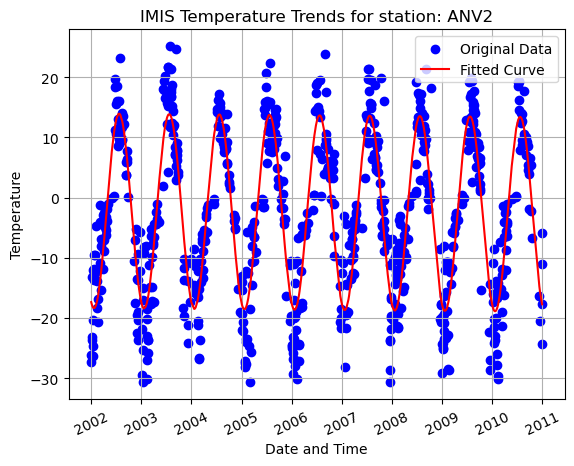

[-2.19298989e+00 -2.08592919e-09 -1.51759080e+01 -5.57582928e+00]
133   -26.226181
134   -27.337083
135   -23.650000
136   -23.211250
137   -13.191667
         ...    
922   -20.492500
923   -11.040139
924    -5.880000
925   -17.711875
926   -24.335000
Name: TSS_30MIN_MEAN, Length: 775, dtype: float64


In [1]:
#THIS IS FOR INTERPOLATED DATA
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def analyze_station(station_name):
    file_path = f"E:\\all folders\\STUDIES\\UZH\\master thesis\\IMIS data\\new data\\new processed data\\TSS_30MIN_MEAN_files\\Stations covering 2000till 2023\\analysis\\interporelated data\\NEW terra night time\\{station_name}.csv"
    df = pd.read_csv(file_path)

    year_column = df.iloc[:, 0]
    month_column = df.iloc[:, 1]
    day_column = df.iloc[:, 2]
    time_column = df.iloc[:, 3]
 
    datetime_column = pd.to_datetime(year_column.astype(str) + '-' + month_column.astype(str) + '-' + day_column.astype(str) + ' ' + time_column)
    temperature_column = df.iloc[:, 4]

    start_date = "2002-01-01"
    end_date = "2010-12-31"
    
    # Filter by date range only
    mask = (datetime_column >= start_date) & (datetime_column < end_date)

    datetime_column = datetime_column[mask]
    temperature_column = temperature_column[mask]

    valid_indices = np.isfinite(temperature_column)
    datetime_column = datetime_column[valid_indices]
    temperature_column = temperature_column[valid_indices]

    # Detect and remove outliers
    z_scores = np.abs((temperature_column - temperature_column.mean()) / temperature_column.std())
    filtered_indices = z_scores < 2  # Adjust threshold as needed
    datetime_column = datetime_column[filtered_indices]
    temperature_column = temperature_column[filtered_indices]

    def harmonic_function(x, b0, b1, b2, b3):
        w = 2 * np.pi / (365.25 * 24 * 60 * 60)  # Frequency in radians per second
        return b0 + (b1 * x) + (b2 * np.cos(w * x)) + (b3 * np.sin(w * x))

    # Convert datetime to seconds since the start date
    time_seconds = (datetime_column - datetime_column.iloc[0]).dt.total_seconds()

    # Fit the harmonic function
    popt, pcov = curve_fit(harmonic_function, time_seconds, temperature_column)

    plt.scatter(datetime_column, temperature_column, color='blue', label='Original Data')
    plt.plot(datetime_column, harmonic_function(np.array(time_seconds), *popt), color='red', label='Fitted Curve')
    plt.xlabel('Date and Time')
    plt.ylabel('Temperature')
    plt.title(f'IMIS Temperature Trends for station: {station_name}')
    plt.legend()
    plt.xticks(rotation=25)
    plt.grid(True)
    plt.show()
    
    return popt, temperature_column, pcov

station_name = "ANV2"
coefficients, temperature_column, pcov = analyze_station(station_name)
print(coefficients)
print(temperature_column)



In [4]:
#THIS DOWNLOADS THE TRENDS OF ALL STATIONS OF THE INTERPOLATED DATA
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import os

def analyze_station(file_path):
    try:
        df = pd.read_csv(file_path)

        # Verify the structure of the CSV file
        expected_columns = 5  # Adjust based on the actual number of columns
        if df.shape[1] < expected_columns:
            raise ValueError(f"Unexpected number of columns: {df.shape[1]}. Expected at least {expected_columns}.")

        year_column = df.iloc[:, 0]
        month_column = df.iloc[:, 1]
        day_column = df.iloc[:, 2]
        time_column = df.iloc[:, 3]

        # Ensure the datetime columns are correctly formatted
        datetime_column = pd.to_datetime(year_column.astype(str) + '-' + month_column.astype(str) + '-' + day_column.astype(str) + ' ' + time_column, errors='coerce')
        if datetime_column.isnull().any():
            raise ValueError("Error parsing datetime columns.")

        temperature_column = df.iloc[:, 4]

        start_date = "2000-01-01"
        end_date = "2023-12-31"

        # Filter by date range only
        mask = (datetime_column >= start_date) & (datetime_column < end_date)

        datetime_column = datetime_column[mask]
        temperature_column = temperature_column[mask]

        valid_indices = np.isfinite(temperature_column)
        datetime_column = datetime_column[valid_indices]
        temperature_column = temperature_column[valid_indices]

        # Detect and remove outliers
        z_scores = np.abs((temperature_column - temperature_column.mean()) / temperature_column.std())
        filtered_indices = z_scores < 2  # Adjust threshold as needed
        datetime_column = datetime_column[filtered_indices]
        temperature_column = temperature_column[filtered_indices]

        def harmonic_function(x, b0, b1, b2, b3):
            w = 2 * np.pi / (365.25 * 24 * 60 * 60)  # Frequency in radians per second
            return b0 + (b1 * x) + (b2 * np.cos(w * x)) + (b3 * np.sin(w * x))

        # Convert datetime to seconds since the start date
        time_seconds = (datetime_column - datetime_column.iloc[0]).dt.total_seconds()

        # Fit the harmonic function
        popt, _ = curve_fit(harmonic_function, time_seconds, temperature_column)
        return popt

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def process_all_stations(directory_path):
    results = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv") and filename != "station_slopes.csv":  # Skip the output file
            file_path = os.path.join(directory_path, filename)
            coefficients = analyze_station(file_path)
            if coefficients is not None:
                b0 = coefficients[0]
                b1 = coefficients[1]
                seconds_per_year = 365.25 * 24 * 60 * 60
                slope = b1 * seconds_per_year
                station_name = filename.split('.')[0]
                results.append([station_name, slope])
            else:
                print(f"Failed to process {filename}")

    results_df = pd.DataFrame(results, columns=["Station", "Slope (Trend)"])
    results_df.to_csv(os.path.join(directory_path, "station_slopes.csv"), index=False)

# Specify the directory containing the CSV files
directory_path = "E:\\all folders\\STUDIES\\UZH\\master thesis\\IMIS data\\new data\\new processed data\\TSS_30MIN_MEAN_files\\Stations covering 2000till 2023\\analysis\\interporelated data\\NEW terra night time\\Filtered_Data"
process_all_stations(directory_path)

Error processing E:\all folders\STUDIES\UZH\master thesis\IMIS data\new data\new processed data\TSS_30MIN_MEAN_files\Stations covering 2000till 2023\analysis\interporelated data\NEW terra night time\Filtered_Data\mean_temperatures.csv: Unexpected number of columns: 2. Expected at least 5.
Failed to process mean_temperatures.csv


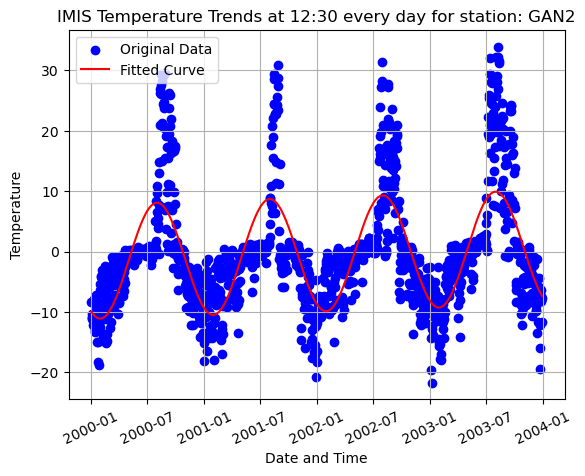

[-1.99703934e+01  1.92855595e-08 -8.22813037e+00 -4.60510445e+00]
53814     -8.4
53862    -10.8
53910    -11.0
53958    -11.1
54006    -10.3
          ... 
122693    -7.4
122741    -8.2
122789    -8.2
122837   -11.7
122885    -7.7
Name: TSS_30MIN_MEAN, Length: 1444, dtype: float64


In [2]:
#THIS IS FOR THE ACTUAL DATA
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def analyze_station(station_name):
    # Construct the file path based on the station name
    file_path = f"E:\\all folders\\STUDIES\\UZH\\master thesis\\IMIS data\\new data\\new processed data\\TSS_30MIN_MEAN_files\\Stations covering 2000till 2023\\{station_name}.csv"

    # Read data from CSV file
    df = pd.read_csv(file_path)

    # Extract datetime and temperature data
    year_column = df['year']
    month_column = df['month']
    day_column = df['day']
    time_column = df['time']

    # Combine year, month, day, and time into a single datetime column
    datetime_column = pd.to_datetime(year_column.astype(str) + '-' + month_column.astype(str) + '-' + day_column.astype(str) + ' ' + time_column)

    # Extract temperature data
    temperature_column = df['TSS_30MIN_MEAN']

    # Define the desired time span (start and end dates)
    start_date = "2000-01-01"
    end_date = "2003-12-31"
    desired_time = "12:30"  # Specify the desired time here

    # Filter the data to include only the desired time span and time of day
    mask = (datetime_column >= start_date) & (datetime_column < end_date) & (datetime_column.dt.strftime('%H:%M') == desired_time)
    datetime_column = datetime_column[mask]
    temperature_column = temperature_column[mask]

    # Remove rows with NaN or infinite values in the temperature column
    valid_indices = np.isfinite(temperature_column)
    datetime_column = datetime_column[valid_indices]
    temperature_column = temperature_column[valid_indices]

    # Define harmonic function with linear trend
    def harmonic_function(x, b0, b1, b2, b3):
        w = 2 * np.pi / (365.25 * 24 * 60 * 60)  # Frequency in radians per second
        return b0 + (b1 * x) + (b2 * np.cos(w * x)) + (b3 * np.sin(w * x))

    # Convert datetime to seconds since 1970-01-01
    xdata = (datetime_column - pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)

    # Provide initial guesses for the parameters
    initial_guess = [temperature_column.mean(), 0, 0, 0]

    # Fit the harmonic function to temperature data
    coefficients, pcov = curve_fit(harmonic_function, xdata, temperature_column, p0=initial_guess)

    # Plot the original data
    plt.scatter(datetime_column, temperature_column, color='blue', label='Original Data')

    # Plot the fitted curve
    plt.plot(datetime_column, harmonic_function(np.array(xdata), *coefficients), color='red', label='Fitted Curve')

    plt.xlabel('Date and Time')
    plt.ylabel('Temperature')
    plt.title(f'IMIS Temperature Trends at {desired_time} every day for station: {station_name}')
    plt.legend()
    plt.xticks(rotation=25)
    plt.grid(True)
    plt.show()
    
    # Return coefficients and temperature_column
    return coefficients, temperature_column

# Example usage:
station_name = "GAN2"
coefficients, temperature_column = analyze_station(station_name)
print(coefficients)
print(temperature_column)

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import os

def analyze_station(file_path):
    try:
        df = pd.read_csv(file_path)

        # Verify the structure of the CSV file
        expected_columns = 5  # Adjust based on the actual number of columns
        if df.shape[1] < expected_columns:
            raise ValueError(f"Unexpected number of columns: {df.shape[1]}. Expected at least {expected_columns}.")

        year_column = df['year']
        month_column = df['month']
        day_column = df['day']
        time_column = df['time']

        # Ensure the datetime columns are correctly formatted
        datetime_column = pd.to_datetime(year_column.astype(str) + '-' + month_column.astype(str) + '-' + day_column.astype(str) + ' ' + time_column, errors='coerce')
        if datetime_column.isnull().any():
            raise ValueError("Error parsing datetime columns.")

        temperature_column = df['TSS_30MIN_MEAN']

        start_date = "2000-01-01"
        end_date = "2023-12-31"

        # Filter by date range only
        mask = (datetime_column >= start_date) & (datetime_column < end_date)

        datetime_column = datetime_column[mask]
        temperature_column = temperature_column[mask]

        valid_indices = np.isfinite(temperature_column)
        datetime_column = datetime_column[valid_indices]
        temperature_column = temperature_column[valid_indices]

        # Detect and remove outliers
        z_scores = np.abs((temperature_column - temperature_column.mean()) / temperature_column.std())
        filtered_indices = z_scores < 2  # Adjust threshold as needed
        datetime_column = datetime_column[filtered_indices]
        temperature_column = temperature_column[filtered_indices]

        def harmonic_function(x, b0, b1, b2, b3):
            w = 2 * np.pi / (365.25 * 24 * 60 * 60)  # Frequency in radians per second
            return b0 + (b1 * x) + (b2 * np.cos(w * x)) + (b3 * np.sin(w * x))

        # Convert datetime to seconds since the start date
        time_seconds = (datetime_column - datetime_column.iloc[0]).dt.total_seconds()

        # Fit the harmonic function
        popt, _ = curve_fit(harmonic_function, time_seconds, temperature_column)
        return popt

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def process_all_stations(directory_path):
    results = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv") and filename != "station_slopes.csv":  # Skip the output file
            file_path = os.path.join(directory_path, filename)
            coefficients = analyze_station(file_path)
            if coefficients is not None:
                b0 = coefficients[0]
                b1 = coefficients[1]
                seconds_per_year = 365.25 * 24 * 60 * 60
                slope = b1 * seconds_per_year
                station_name = filename.split('.')[0]
                results.append([station_name, slope])
            else:
                print(f"Failed to process {filename}")

    results_df = pd.DataFrame(results, columns=["Station", "Slope (Trend)"])
    results_df.to_csv(os.path.join(directory_path, "station_slopes.csv"), index=False)

# Specify the directory containing the CSV files
directory_path = "E:\\all folders\\STUDIES\\UZH\\master thesis\\IMIS data\\new data\\new processed data\\TSS_30MIN_MEAN_files\\Stations covering 2000till 2023"
process_all_stations(directory_path)


In [ ]:
#THE CODE THAT MUST GIVE THE HOURLY SLOPES (THIS IS MAINLY THE USED ONE)
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

def analyze_station(station_name, desired_time):
    # Construct the file path based on the station name
    file_path = f"E:\\all folders\\STUDIES\\UZH\\master thesis\\IMIS data\\new data\\new processed data\\TSS_30MIN_MEAN_files\\Stations covering 2000till 2023\\{station_name}.csv"

    try:
        # Read data from CSV file
        df = pd.read_csv(file_path)

        # Extract datetime and temperature data
        datetime_column = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['day'].astype(str) + ' ' + df['time'])
        temperature_column = df['TSS_30MIN_MEAN']

        # Define the desired time span (start and end dates)
        start_date = "2000-01-01"
        end_date = "2023-12-31"

        # Filter the data to include only the desired time span and time of day
        mask = (datetime_column >= start_date) & (datetime_column < end_date) & (datetime_column.dt.strftime('%H:%M') == desired_time)
        datetime_column = datetime_column[mask]
        temperature_column = temperature_column[mask]

        # Remove rows with NaN or infinite values in the temperature column
        valid_indices = np.isfinite(temperature_column)
        datetime_column = datetime_column[valid_indices]
        temperature_column = temperature_column[valid_indices]

        if len(datetime_column) > 0:
            # Define harmonic function with linear trend
            def harmonic_function(x, b0, b1, b2, b3):
                w = 2 * np.pi / (365.25 * 24 * 60 * 60)  # Frequency in radians per second
                return b0 + (b1 * x) + (b2 * np.cos(w * x)) + (b3 * np.sin(w * x))

            # Convert datetime to seconds since 1970-01-01
            xdata = (datetime_column - pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)

            # Provide initial guesses for the parameters
            initial_guess = [temperature_column.mean(), 0, 0, 0]

            # Fit the harmonic function to temperature data
            coefficients, pcov = curve_fit(harmonic_function, xdata, temperature_column, p0=initial_guess)

            # Extract slope (trend) coefficient
            slope = coefficients[1]

            # Number of seconds in a year
            seconds_per_year = 365.25 * 24 * 60 * 60

            # Convert slope from temperature per second to temperature per year
            slope_per_year = slope * seconds_per_year

            # Return slope per year
            return slope_per_year
        else:
            return np.nan
    except FileNotFoundError:
        print(f"Data file not found for station: {station_name}")
        return np.nan

# List of station names and desired times
station_names =['AMD2', 'ANV2', 'ANV3', 'ARO2', 'ARO3', 'ATT2', 'BED3', 'BER2', 'BER3', 'BEV2',
 'BOG2', 'CAM2', 'CHA2', 'CMA2', 'DAV2', 'DAV3', 'DIA2', 'DTR2', 'EGH2', 'ELM2', 'ELS2',
 'FAE2', 'FIR2', 'FIS2', 'FNH2', 'FUL2', 'GAD2', 'GAN2', 'GLA2', 'GOM2', 'GOM3', 'GOR2', 
 'GUT2', 'ILI2', 'JUL2', 'KES2', 'KLO2', 'KLO3', 'LAG2', 'LAU2', 'LUK2', 'MAE2', 'MEI2', 
 'MTR2', 'MUN2', 'NAR2', 'NAS2', 'OBM2', 'OBW2', 'OBW3', 'ORT2', 'OTT2', 'PAR2', 'PMA2', 
 'PUZ2', 'ROA2', 'SAA2', 'SCA2', 'SCA3', 'SCB2', 'SCH2', 'SIM2', 'SLF2', 'SMN2', 'SPN2', 
 'SPN3', 'STH2', 'STN2', 'TAM2', 'TAM3', 'TIT2', 'TRU2', 'TUJ2', 'TUM2', 'URS2', 'VAL2', 
 'VDS2', 'VIN2', 'WFJ2', 'ZER2']
 # Add more station names here
desired_times = ["00:00", "00:30", "01:00", "01:30", "02:00", "02:30", "03:00", "03:30",
              "04:00", "04:30", "05:00", "05:30", "06:00", "06:30", "07:00", "07:30",
              "08:00", "08:30", "09:00", "09:30", "10:00", "10:30", "11:00", "11:30",
              "12:00", "12:30", "13:00", "13:30", "14:00", "14:30", "15:00", "15:30",
              "16:00", "16:30", "17:00", "17:30", "18:00", "18:30", "19:00", "19:30",
              "20:00", "20:30", "21:00", "21:30", "22:00", "22:30", "23:00", "23:30"]  # Specify desired times here

# Create a dictionary to store hourly slope values for each station
hourly_slopes = {}

# Calculate hourly slope values for each station and desired time
for station_name in station_names:
    hourly_slopes[station_name] = {}
    for desired_time in desired_times:
        slope = analyze_station(station_name, desired_time)
        hourly_slopes[station_name][desired_time] = slope

# Create a DataFrame to display the results
results_df = pd.DataFrame(hourly_slopes)


# Print the DataFrame
print(results_df)
results_df.T.to_csv(r"E:\all folders\STUDIES\UZH\master thesis\IMIS data\new data\new processed data\TSS_30MIN_MEAN_files\Stations covering 2000till 2023\new_hourly_trends_new_code.csv", index_label='Time')